<a href="https://colab.research.google.com/github/Saurabhganvir/M5_forecasting_validation/blob/main/M5_accuracy_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

In [2]:
import zipfile
import os
with zipfile.ZipFile("m5-forecasting-accuracy.zip", "r") as zip_ref:
  zip_ref.extractall(".")

#verify extraction
print("Extracted files:")
for file in os.listdir("."):
  print(file)

Extracted files:
.config
m5-forecasting-accuracy.zip
sample_submission.csv
sales_train_evaluation.csv
calendar.csv
sell_prices.csv
sales_train_validation.csv
sample_data


In [10]:
# ================================
# M5 Forecasting Accuracy - EDA (Colab Optimized)
# ================================

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# 2. Load Data (only once, with efficient dtypes)
calendar = pd.read_csv("calendar.csv")
prices   = pd.read_csv("sell_prices.csv")
sales    = pd.read_csv("sales_train_evaluation.csv")

# Optimize dtypes
for c in sales.columns:
    if c.startswith("d_"):
        sales[c] = sales[c].astype("int16")
prices["sell_price"] = prices["sell_price"].astype("float32")

# Convert calendar to datetime and filter out 2011 & 2012
calendar["date"] = pd.to_datetime(calendar["date"])
calendar = calendar[calendar["date"].dt.year >= 2013]

# Keep only relevant day columns (from 2013 onwards)
valid_days = set(calendar["d"].unique())
day_cols = [c for c in sales.columns if c in valid_days]

print(f"Keeping {len(day_cols)} day columns out of {sales.filter(like='d_').shape[1]}")


Keeping 1238 day columns out of 1941


Date range: 2013-01-01 00:00:00 to 2016-06-19 00:00:00
Unique events: ['NewYear' 'OrthodoxChristmas' 'MartinLutherKingDay' 'SuperBowl'
 'LentStart' 'ValentinesDay' 'PresidentsDay' 'LentWeek2' 'Purim End'
 'StPatricksDay' 'Easter' 'Pesach End' 'OrthodoxEaster' "Mother's day"
 'MemorialDay' 'NBAFinalsStart' "Father's day" 'NBAFinalsEnd'
 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr' 'LaborDay' 'ColumbusDay'
 'EidAlAdha' 'Halloween' 'VeteransDay' 'Thanksgiving' 'Chanukah End'
 'Christmas' 'Cinco De Mayo']


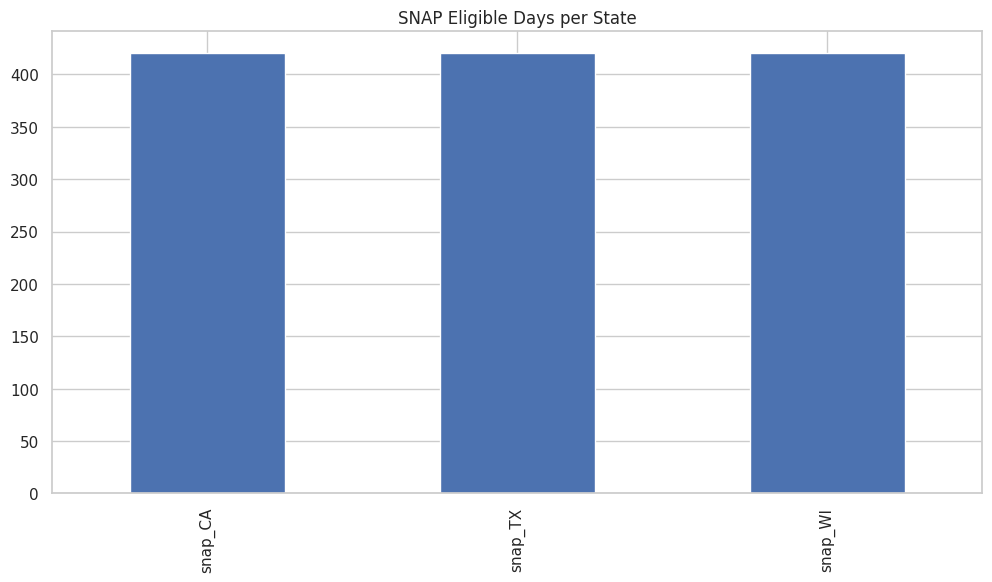

In [11]:
print("Date range:", calendar["date"].min(), "to", calendar["date"].max())
print("Unique events:", calendar["event_name_1"].dropna().unique())

# sns.countplot(x="weekday", data=calendar,
#               order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
# plt.title("Count of Days per Weekday")
# plt.show()

calendar[["snap_CA","snap_TX","snap_WI"]].sum().plot(kind="bar")
plt.title("SNAP Eligible Days per State")
plt.show()


Prices shape after filtering: (5088563, 4)


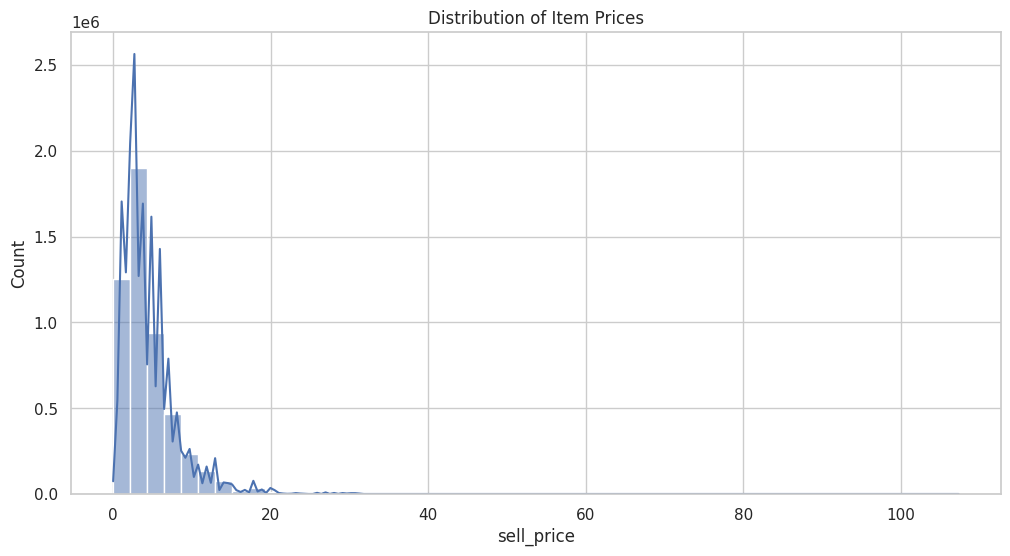

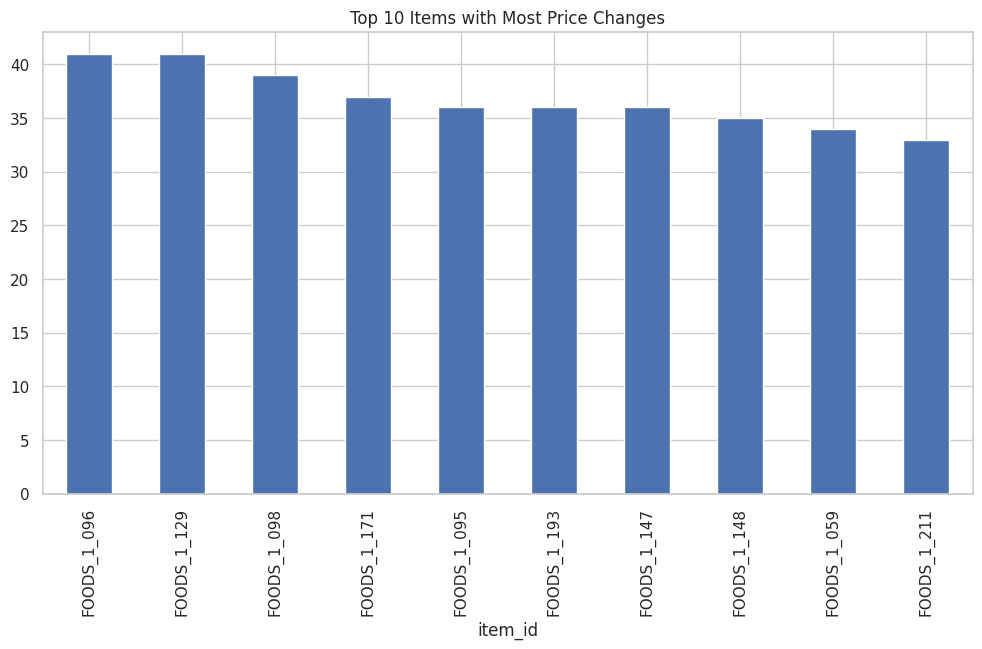

In [12]:
# Reduce size by keeping only 2013 onwards
prices = prices[prices["wm_yr_wk"].isin(calendar["wm_yr_wk"].unique())]

print("Prices shape after filtering:", prices.shape)

sns.histplot(prices["sell_price"], bins=50, kde=True)
plt.title("Distribution of Item Prices")
plt.show()

# Top 10 items with most price changes
item_price_var = prices.groupby("item_id")["sell_price"].nunique().sort_values(ascending=False).head(10)
item_price_var.plot(kind="bar")
plt.title("Top 10 Items with Most Price Changes")
plt.show()


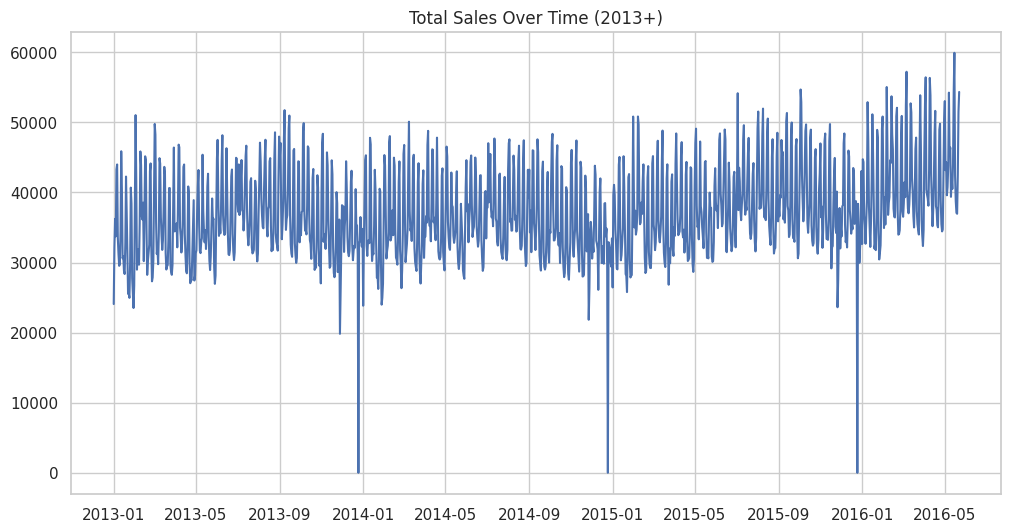

In [13]:
# Aggregate total sales per day directly (no melt)
daily_sales = sales[day_cols].sum().reset_index()
daily_sales.columns = ["d","total_sales"]

# Merge with calendar to get dates
daily_sales = daily_sales.merge(calendar[["d","date"]], on="d", how="left")

# Plot total sales
plt.plot(daily_sales["date"], daily_sales["total_sales"])
plt.title("Total Sales Over Time (2013+)")
plt.show()


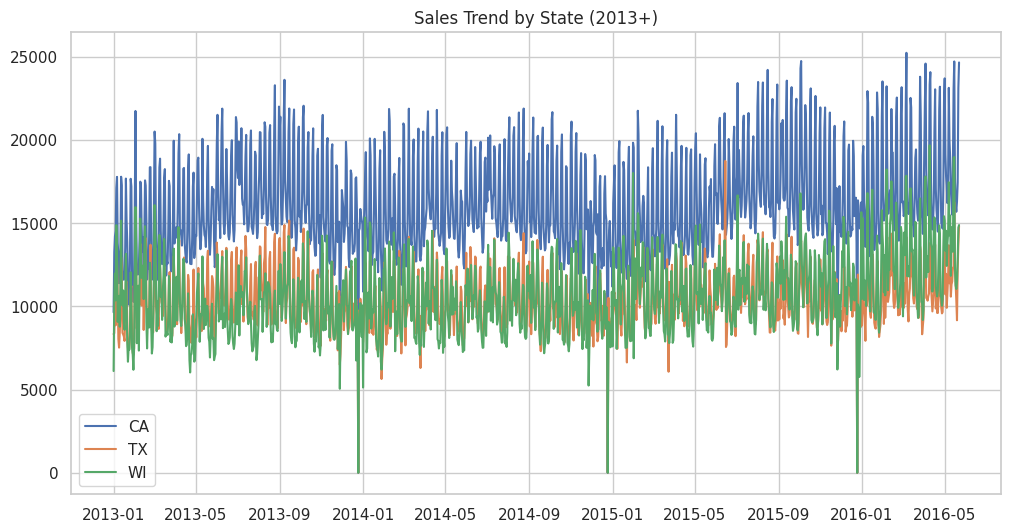

In [14]:
# Sum per state without melting everything
state_sales = {}
for state in sales["state_id"].unique():
    tmp = sales[sales["state_id"]==state]
    totals = tmp[day_cols].sum().reset_index()
    totals.columns = ["d","sales"]
    totals = totals.merge(calendar[["d","date"]], on="d", how="left")
    state_sales[state] = totals

for state, df in state_sales.items():
    plt.plot(df["date"], df["sales"], label=state)
plt.legend()
plt.title("Sales Trend by State (2013+)")
plt.show()


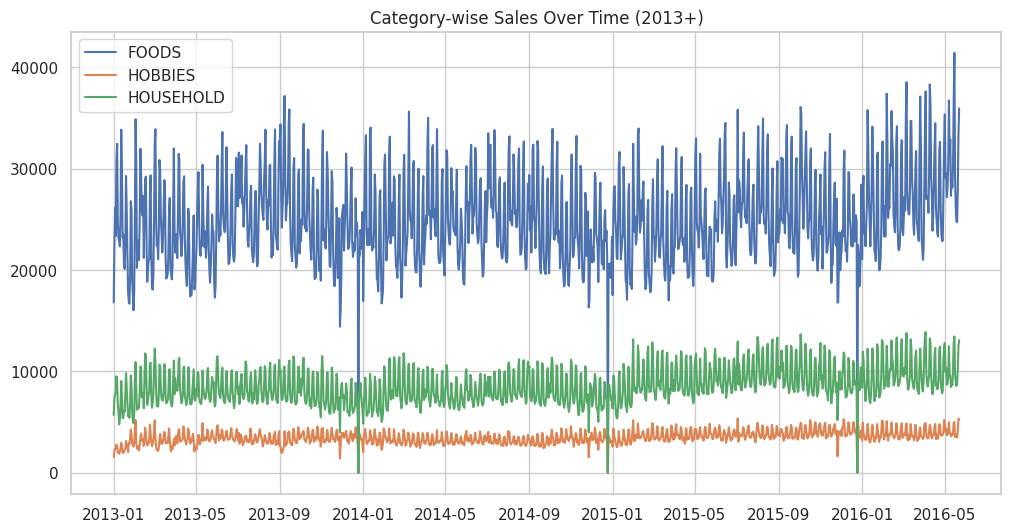

In [15]:
# Aggregate category sales
cat_sales = sales.groupby("cat_id")[day_cols].sum().T.reset_index()
cat_sales = cat_sales.rename(columns={"index":"d"})
cat_sales = cat_sales.merge(calendar[["d","date"]], on="d", how="left")

for cat in cat_sales.drop(columns=["d","date"]).columns:
    plt.plot(cat_sales["date"], cat_sales[cat], label=cat)
plt.legend()
plt.title("Category-wise Sales Over Time (2013+)")
plt.show()


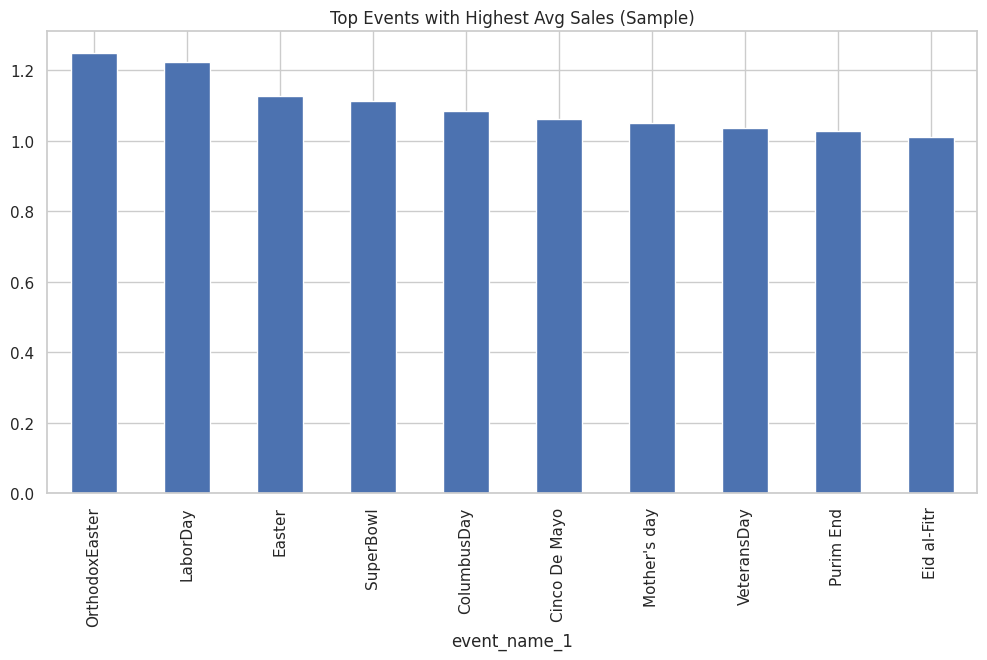

In [16]:
# Use a random sample of items to save memory
sample_ids = sales["id"].sample(200, random_state=42)

sample_sales = sales[sales["id"].isin(sample_ids)]
sample_sales = sample_sales.melt(
    id_vars=["id","item_id","dept_id","cat_id","store_id","state_id"],
    value_vars=day_cols,
    var_name="d", value_name="sales"
)

sample_sales = sample_sales.merge(calendar[["d","date","event_name_1"]], on="d", how="left")

event_sales = sample_sales.groupby("event_name_1")["sales"].mean().dropna().sort_values(ascending=False).head(10)
event_sales.plot(kind="bar")
plt.title("Top Events with Highest Avg Sales (Sample)")
plt.show()


In [17]:
# ================================
# Final EDA Insights Summary
# ================================

print("🔎 Generating EDA Insights Summary...")

# 1. Top categories by total sales
cat_totals = sales.groupby("cat_id")[day_cols].sum().sum(axis=1).sort_values(ascending=False)

# 2. Top departments by total sales
dept_totals = sales.groupby("dept_id")[day_cols].sum().sum(axis=1).sort_values(ascending=False)

# 3. Top events driving sales (sample-based to save memory)
event_means = sample_sales.groupby("event_name_1")["sales"].mean().dropna().sort_values(ascending=False).head(5)

# 4. State-wise average daily sales
state_avg = {state: df["sales"].mean() for state, df in state_sales.items()}

# 5. Zero-sales prevalence (sample-based)
zero_sales_ratio = sample_sales.groupby("id")["sales"].apply(lambda x: (x==0).mean()).mean()

# -------------------------
# Print Human-readable Summary
# -------------------------
print("\n📊 CATEGORY INSIGHTS")
print("Top categories by total sales:")
for cat, val in cat_totals.head(3).items():
    print(f" - {cat}: {int(val)} units")

print("\n📊 DEPARTMENT INSIGHTS")
print("Top departments by total sales:")
for dept, val in dept_totals.head(3).items():
    print(f" - {dept}: {int(val)} units")

print("\n📅 EVENT INSIGHTS")
print("Events with highest average sales (sample-based):")
for ev, val in event_means.items():
    print(f" - {ev}: {val:.2f} avg units")

print("\n🏪 STATE INSIGHTS")
for st, avg in state_avg.items():
    print(f" - {st}: {avg:.2f} avg daily sales")

print("\n📉 ZERO-SALES INSIGHTS")
print(f"On average, ~{zero_sales_ratio*100:.1f}% of days show zero sales per item (sample-based).")

print("\n✅ EDA Summary Completed.")


🔎 Generating EDA Insights Summary...

📊 CATEGORY INSIGHTS
Top categories by total sales:
 - FOODS: 31003295 units
 - HOUSEHOLD: 10663788 units
 - HOBBIES: 4341668 units

📊 DEPARTMENT INSIGHTS
Top departments by total sales:
 - FOODS_3: 22096993 units
 - HOUSEHOLD_1: 8569594 units
 - FOODS_2: 5337164 units

📅 EVENT INSIGHTS
Events with highest average sales (sample-based):
 - OrthodoxEaster: 1.25 avg units
 - LaborDay: 1.23 avg units
 - Easter: 1.13 avg units
 - SuperBowl: 1.11 avg units
 - ColumbusDay: 1.08 avg units

🏪 STATE INSIGHTS
 - CA: 16142.51 avg daily sales
 - TX: 10424.65 avg daily sales
 - WI: 10596.61 avg daily sales

📉 ZERO-SALES INSIGHTS
On average, ~64.7% of days show zero sales per item (sample-based).

✅ EDA Summary Completed.


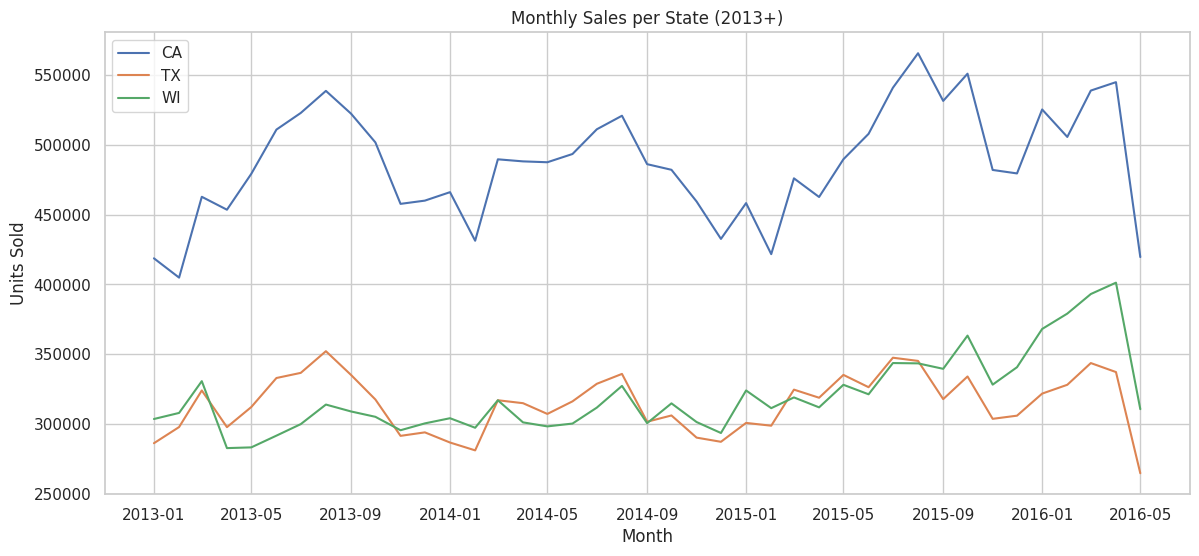

📅 Monthly Sales Summary per State:
 - CA: highest sales in August 2015 with 565672 units sold.
 - TX: highest sales in August 2013 with 352173 units sold.
 - WI: highest sales in April 2016 with 401284 units sold.


In [18]:
# ================================
# Monthly Sales Comparison per State
# ================================

# Merge day_cols with calendar dates
day_sales = sales[["state_id"] + day_cols].groupby("state_id").sum().T.reset_index()
day_sales = day_sales.rename(columns={"index":"d"})
day_sales = day_sales.merge(calendar[["d","date"]], on="d", how="left")

# Add year-month column
day_sales["year_month"] = day_sales["date"].dt.to_period("M")

# Aggregate by month & state
monthly_sales = (
    day_sales.groupby(["year_month"])
    [["CA","TX","WI"]]  # the state_id columns
    .sum()
    .reset_index()
)

# Convert back to datetime for plotting
monthly_sales["year_month"] = monthly_sales["year_month"].dt.to_timestamp()

# Plot
plt.figure(figsize=(14,6))
for state in ["CA","TX","WI"]:
    plt.plot(monthly_sales["year_month"], monthly_sales[state], label=state)

plt.legend()
plt.title("Monthly Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.show()

# -------------------------
# Text-based insight summary
# -------------------------
print("📅 Monthly Sales Summary per State:")
for state in ["CA","TX","WI"]:
    top_month = monthly_sales.sort_values(state, ascending=False).iloc[0]
    print(f" - {state}: highest sales in {top_month['year_month'].strftime('%B %Y')} "
          f"with {int(top_month[state])} units sold.")


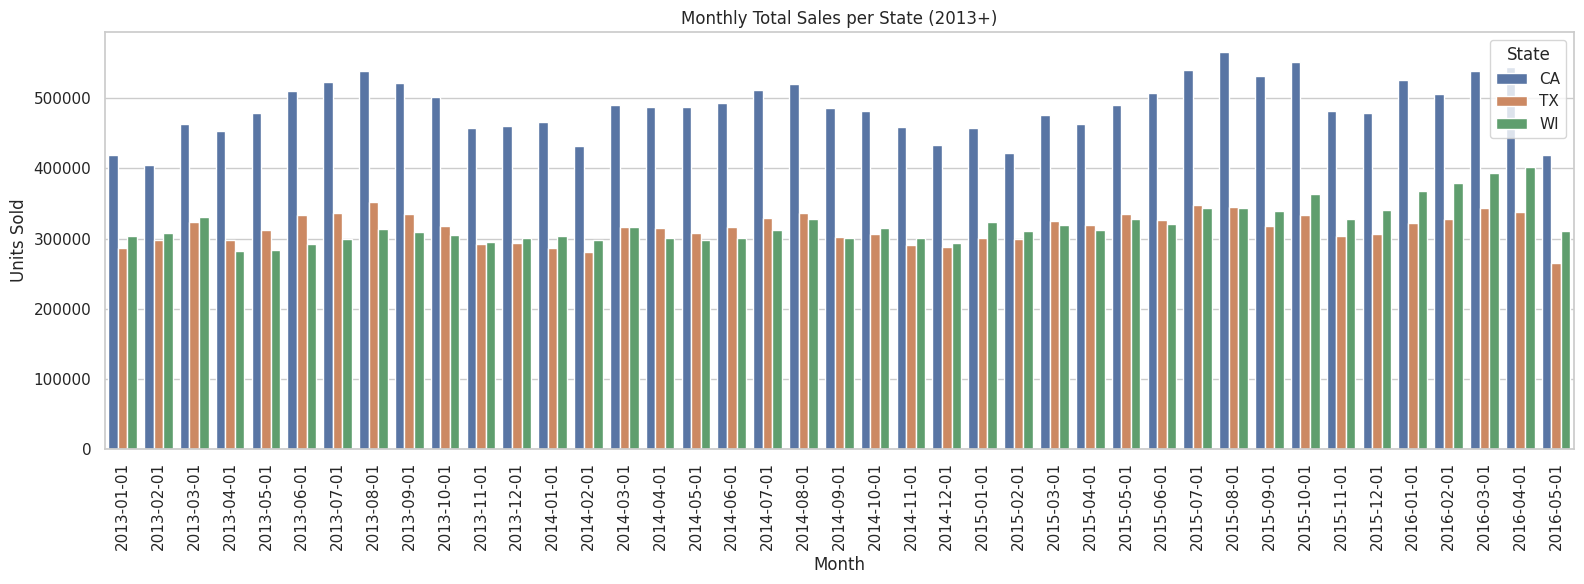

📊 Bar Chart Insight:
 - Compare states side by side each month.
 - Useful for spotting if one state consistently dominates sales, or if seasonality differs.


In [19]:
# ================================
# Monthly Sales Comparison per State (Bar Plot)
# ================================

import seaborn as sns

# Reuse monthly_sales from earlier step
# monthly_sales: columns -> [year_month, CA, TX, WI]

# Melt into long format for seaborn
monthly_sales_melted = monthly_sales.melt(
    id_vars="year_month",
    value_vars=["CA","TX","WI"],
    var_name="state",
    value_name="units_sold"
)

# Plot grouped bar chart
plt.figure(figsize=(16,6))
sns.barplot(
    data=monthly_sales_melted,
    x="year_month", y="units_sold", hue="state"
)
plt.xticks(rotation=90)
plt.title("Monthly Total Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------
# Text-based insights
# -------------------------
print("📊 Bar Chart Insight:")
print(" - Compare states side by side each month.")
print(" - Useful for spotting if one state consistently dominates sales, or if seasonality differs.")


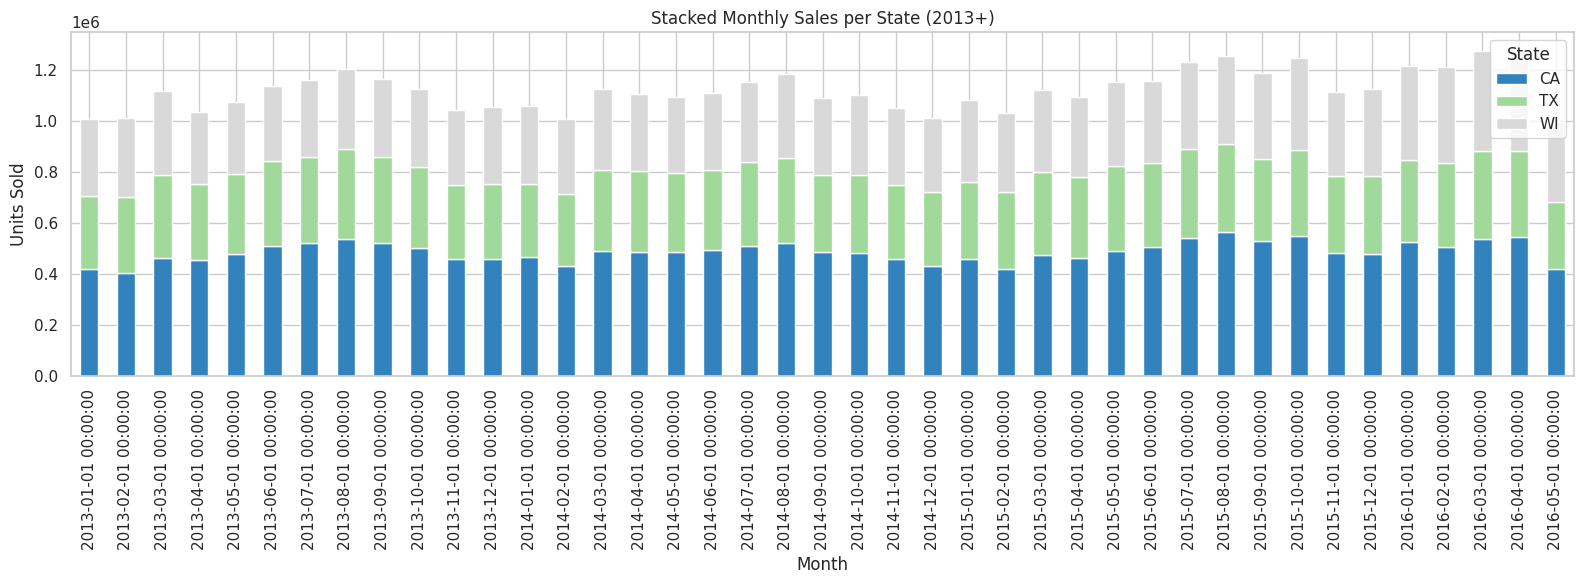

📊 Stacked Bar Insight:
 - Height of bar = total monthly sales across all states.
 - Each color segment = state’s contribution.
 - Useful for spotting seasonal peaks and proportion differences.


In [20]:
# ================================
# Stacked Bar Plot: Monthly Sales per State
# ================================

# Pivot to wide format (already in monthly_sales)
stacked_df = monthly_sales.set_index("year_month")[["CA","TX","WI"]]

# Plot stacked bar chart
stacked_df.plot(
    kind="bar",
    stacked=True,
    figsize=(16,6),
    colormap="tab20c"
)
plt.title("Stacked Monthly Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.xticks(rotation=90)
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------
# Text-based insights
# -------------------------
print("📊 Stacked Bar Insight:")
print(" - Height of bar = total monthly sales across all states.")
print(" - Each color segment = state’s contribution.")
print(" - Useful for spotting seasonal peaks and proportion differences.")


In [26]:
# ================================
# Events in August
# ================================

# Filter for August (month == 8)
august_calendar = calendar[calendar["date"].dt.month == 8]

# List all unique events in August
aug_events = august_calendar["event_name_1"].dropna().unique()
print("📅 Unique Events in August:")
for ev in aug_events:
    print(" -", ev)


# Count how many times each event occurs in August
event_counts = august_calendar["event_name_1"].value_counts()
print("\n📊 Event Occurrences in August:")
print(event_counts)

# # Optional: visualize event distribution in August
# sns.countplot(
#     x="event_name_1",
#     data=august_calendar[august_calendar["event_name_1"].notnull()],
#     order=event_counts.index
# )
# plt.xticks(rotation=90)
# plt.title("Event Distribution in August")
# plt.ylabel("Number of Days")
# plt.xlabel("Event Name")
# plt.tight_layout()
# plt.show()


📅 Unique Events in August:
 - Eid al-Fitr

📊 Event Occurrences in August:
event_name_1
Eid al-Fitr    1
Name: count, dtype: int64


/tmp/ipython-input-497078373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  august_sample["is_event"] = np.where(august_sample["event_name_1"].notnull(), 1, 0)


📊 Average Sales per State: Event vs Non-Event Days (August Sample)
          Non-Event Days  Event Days
state_id                            
CA              1.607337    1.472222
TX              0.839275    0.600000
WI              0.632075    0.603774


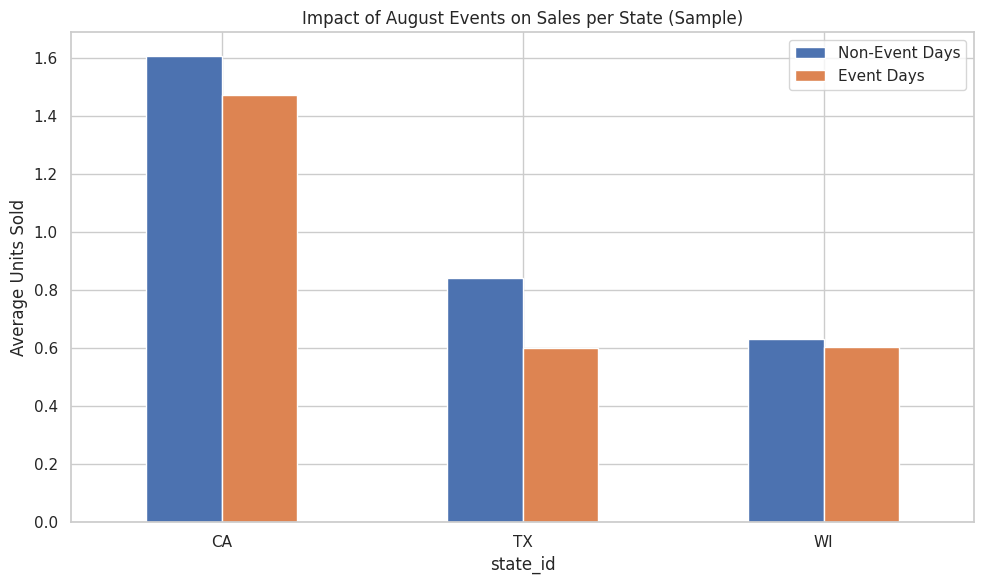

In [27]:
# ================================
# August Events vs Sales per State
# ================================

# Filter sales_long sample to August (or create small sample if memory is tight)
# We'll use previously created sample_sales for events analysis
august_sample = sample_sales[sample_sales["date"].dt.month == 8]

# Add a column: is_event (1 if event_name_1 exists, else 0)
august_sample["is_event"] = np.where(august_sample["event_name_1"].notnull(), 1, 0)

# Aggregate average sales per state on event vs non-event days
state_event_sales = august_sample.groupby(["state_id", "is_event"])["sales"].mean().reset_index()

# Pivot for easier plotting
state_event_pivot = state_event_sales.pivot(index="state_id", columns="is_event", values="sales")
state_event_pivot.columns = ["Non-Event Days", "Event Days"]
print("📊 Average Sales per State: Event vs Non-Event Days (August Sample)")
print(state_event_pivot)

# Optional: visualize comparison
state_event_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Impact of August Events on Sales per State (Sample)")
plt.ylabel("Average Units Sold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


📊 Average Sales per State: SNAP vs Non-SNAP Days (August Sample)
snap_flag  Non-SNAP Day  SNAP Day
state_id                         
CA             1.593474  1.631944
TX             0.793862  0.926667
WI             0.583109  0.733962


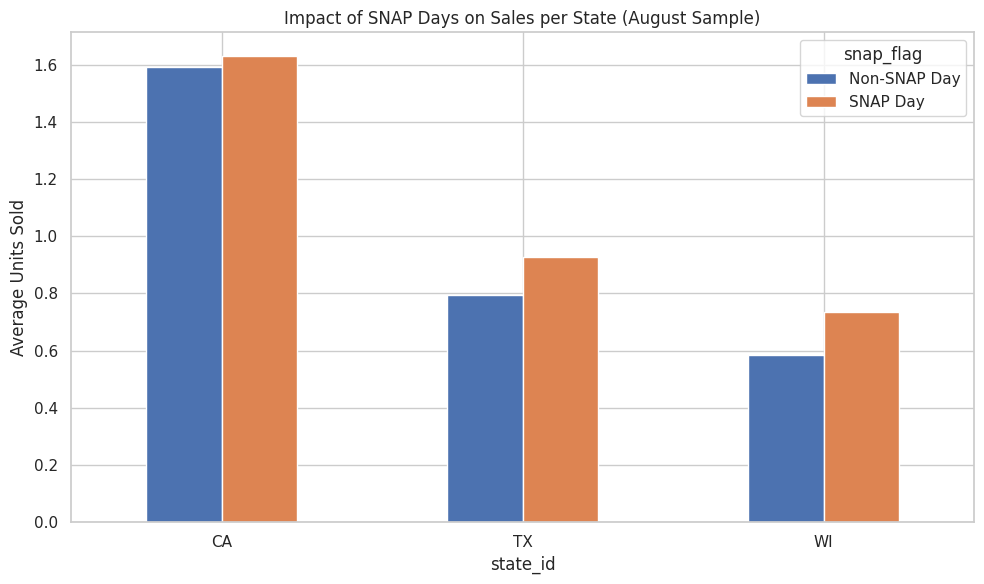

In [28]:
# ================================
# SNAP Impact on Sales in August
# ================================

# 1. Filter calendar for August
august_calendar = calendar[calendar["date"].dt.month == 8]

# 2. Merge with sample_sales (already has 'date', 'state_id', 'sales')
august_sales = sample_sales.merge(
    august_calendar[["date","snap_CA","snap_TX","snap_WI"]],
    on="date",
    how="left"
)

# 3. Create a SNAP flag per row based on state
def snap_flag(row):
    if row["state_id"] == "CA":
        return row["snap_CA"]
    elif row["state_id"] == "TX":
        return row["snap_TX"]
    elif row["state_id"] == "WI":
        return row["snap_WI"]
    else:
        return 0

august_sales["snap_flag"] = august_sales.apply(snap_flag, axis=1)

# 4. Aggregate: average sales on SNAP vs non-SNAP days per state
snap_sales = august_sales.groupby(["state_id","snap_flag"])["sales"].mean().reset_index()
snap_sales["snap_flag"] = snap_sales["snap_flag"].map({0:"Non-SNAP Day",1:"SNAP Day"})

# Pivot for plotting
snap_sales_pivot = snap_sales.pivot(index="state_id", columns="snap_flag", values="sales")

# 5. Display results
print("📊 Average Sales per State: SNAP vs Non-SNAP Days (August Sample)")
print(snap_sales_pivot)

# 6. Bar plot
snap_sales_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Impact of SNAP Days on Sales per State (August Sample)")
plt.ylabel("Average Units Sold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# ================================
# SNAP Allowed Dates per State
# ================================

# Filter calendar for SNAP days
snap_dates = calendar[["date","snap_CA","snap_TX","snap_WI"]]

# Function to print dates per state
def print_snap_dates(state_col, state_name):
    dates = snap_dates[snap_dates[state_col]==1]["date"]
    print(f"\n📅 SNAP Allowed Dates in {state_name}:")
    for d in dates.dt.strftime('%Y-%m-%d'):
        print(" -", d)

# Print for each state
print_snap_dates("snap_CA", "California")
print_snap_dates("snap_TX", "Texas")
print_snap_dates("snap_WI", "Wisconsin")


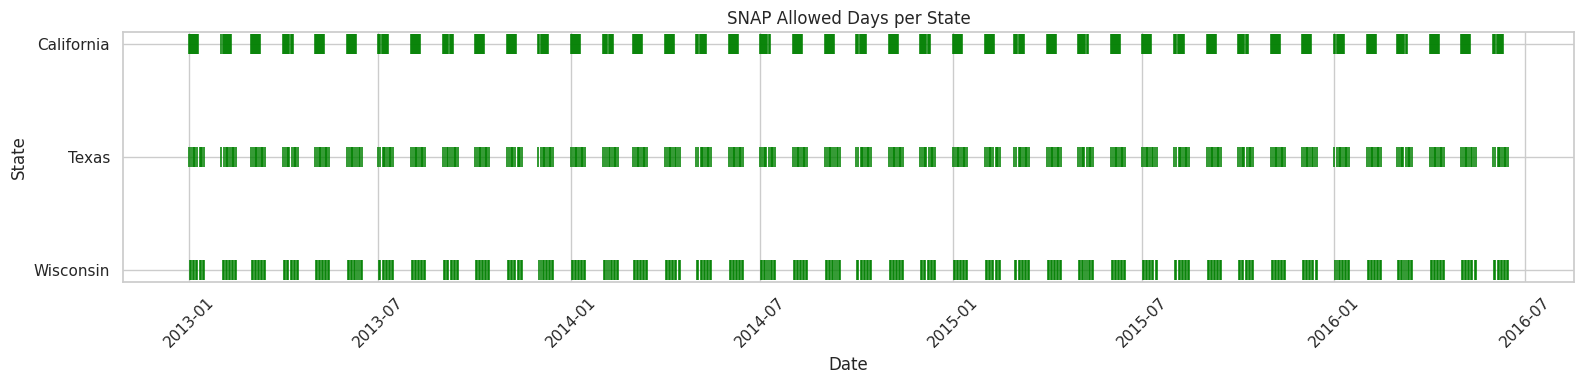

In [30]:
# ================================
# Plot SNAP Days per State
# ================================

import matplotlib.dates as mdates

# Prepare data in long format for plotting
snap_long = snap_dates.melt(
    id_vars="date",
    value_vars=["snap_CA","snap_TX","snap_WI"],
    var_name="state",
    value_name="snap_flag"
)

# Map state column to readable names
snap_long["state"] = snap_long["state"].map({
    "snap_CA":"California",
    "snap_TX":"Texas",
    "snap_WI":"Wisconsin"
})

# Keep only SNAP days
snap_long = snap_long[snap_long["snap_flag"]==1]

# Plot
plt.figure(figsize=(16,4))
sns.scatterplot(data=snap_long, x="date", y="state", marker="|", s=200, color="green")

plt.title("SNAP Allowed Days per State")
plt.xlabel("Date")
plt.ylabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4242165147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_dates["year_month"] = snap_dates["date"].dt.to_period("M")


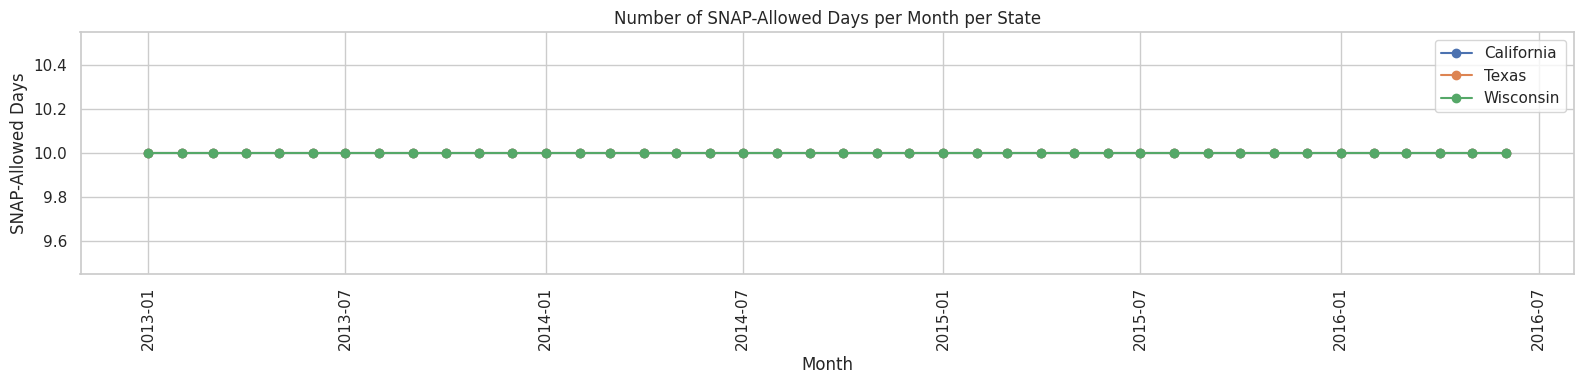

📊 SNAP Days in August per State:
   year_month  California  Texas  Wisconsin
7  2013-08-01          10     10         10
19 2014-08-01          10     10         10
31 2015-08-01          10     10         10


In [32]:
# ================================
# Compare SNAP Days per Month
# ================================

# Add year-month column
snap_dates["year_month"] = snap_dates["date"].dt.to_period("M")

# Aggregate: sum of SNAP days per month per state
snap_monthly = snap_dates.groupby("year_month")[["snap_CA","snap_TX","snap_WI"]].sum().reset_index()

# Convert year_month to datetime for plotting
snap_monthly["year_month"] = snap_monthly["year_month"].dt.to_timestamp()

# Rename columns for readability
snap_monthly = snap_monthly.rename(columns={
    "snap_CA":"California",
    "snap_TX":"Texas",
    "snap_WI":"Wisconsin"
})

# Plot line chart
plt.figure(figsize=(16,4))
for state in ["California","Texas","Wisconsin"]:
    plt.plot(snap_monthly["year_month"], snap_monthly[state], marker="o", label=state)

plt.title("Number of SNAP-Allowed Days per Month per State")
plt.xlabel("Month")
plt.ylabel("SNAP-Allowed Days")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: highlight August
august_snap = snap_monthly[snap_monthly["year_month"].dt.month == 8]
print("📊 SNAP Days in August per State:")
print(august_snap[["year_month","California","Texas","Wisconsin"]])


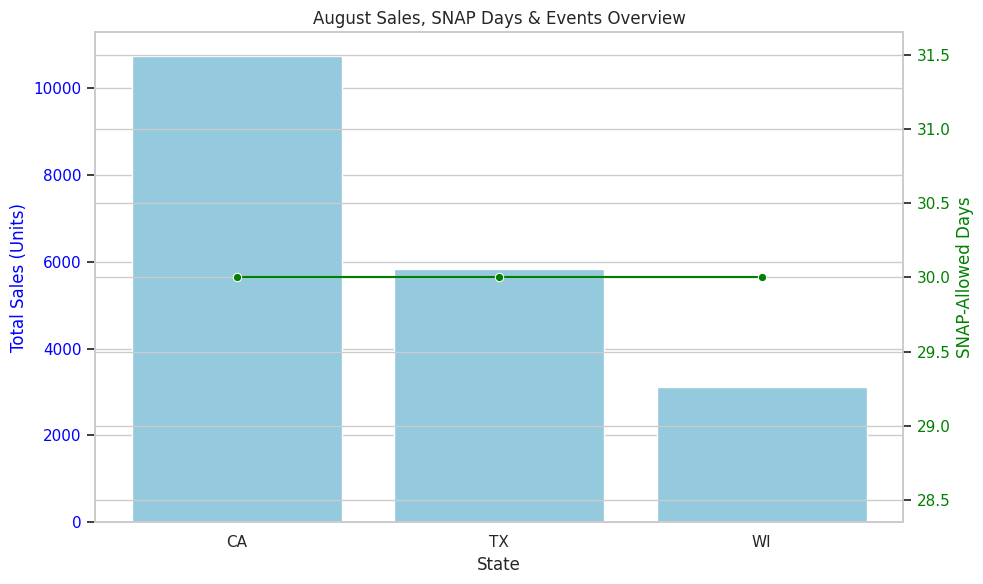

📊 August Sales Insights:
 - CA: 10753 units sold, 30 SNAP-allowed days.
 - TX: 5836 units sold, 30 SNAP-allowed days.
 - WI: 3114 units sold, 30 SNAP-allowed days.

📅 Number of unique events in August: 1
Events include: Eid al-Fitr

🏷 Top 3 categories contributing to August sales (sample-based):
 - FOODS: 13439 units sold
 - HOUSEHOLD: 3560 units sold
 - HOBBIES: 2704 units sold

✅ August Sales Insights Completed.


In [36]:
# ================================
# Why Sales Spike in August? Combined Analysis
# ================================

# 1️⃣ Filter August sales (sample for memory efficiency)
august_sales_sample = sample_sales[sample_sales["date"].dt.month == 8]

# Aggregate total units sold per state
aug_state_sales = august_sales_sample.groupby("state_id")["sales"].sum().reset_index()
aug_state_sales.columns = ["State","Total Sales"]

# 2️⃣ Count SNAP-allowed days in August
aug_snap = calendar[calendar["date"].dt.month==8]
snap_counts = {
    "CA": aug_snap["snap_CA"].sum(), # Changed key to 'CA'
    "TX": aug_snap["snap_TX"].sum(), # Changed key to 'TX'
    "WI": aug_snap["snap_WI"].sum()  # Changed key to 'WI'
}
snap_df = pd.DataFrame(list(snap_counts.items()), columns=["State","SNAP Days"])

# 3️⃣ Count unique events in August
aug_events = august_calendar["event_name_1"].dropna().unique()
num_events = len(aug_events)

# 4️⃣ Top contributing categories in August (sample-based)
cat_sales_aug = august_sales_sample.groupby("cat_id")["sales"].sum().sort_values(ascending=False)
top_categories = cat_sales_aug.head(3)

# -------------------------
# Plot August Sales + SNAP Days per State
# -------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for total sales
sns.barplot(x="State", y="Total Sales", data=aug_state_sales, ax=ax1, color="skyblue")
ax1.set_ylabel("Total Sales (Units)", color="blue")
ax1.set_title("August Sales, SNAP Days & Events Overview")
ax1.tick_params(axis='y', labelcolor="blue")

# Line plot for SNAP Days (secondary axis)
ax2 = ax1.twinx()
sns.lineplot(x="State", y="SNAP Days", data=snap_df, ax=ax2, marker="o", color="green")
ax2.set_ylabel("SNAP-Allowed Days", color="green")
ax2.tick_params(axis='y', labelcolor="green")

plt.tight_layout()
plt.show()

# -------------------------
# Text-based Summary
# -------------------------
print("📊 August Sales Insights:")
for idx, row in aug_state_sales.iterrows():
    state = row["State"]
    print(f" - {state}: {row['Total Sales']} units sold, {snap_counts[state]} SNAP-allowed days.")

print(f"\n📅 Number of unique events in August: {num_events}")
print("Events include:", ", ".join(aug_events))

print("\n🏷 Top 3 categories contributing to August sales (sample-based):")
for cat, val in top_categories.items():
    print(f" - {cat}: {int(val)} units sold")

print("\n✅ August Sales Insights Completed.")